# Training a restricted Boltzmann machine (RBM)
### Application to the MNIST dataset

YJ Choe (yjchoe@cmu.edu)

#### Setup

In [1]:
%cd ../code/NN/

/Users/YJ/Dropbox/Code/deep_learning/hw2/code/NN


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rbm import RBM
from nn.utils import load_data, binarize_data
from nn.visualization import print_image

#### Load and binarize data

In [3]:
X_train, X_valid, X_test, y_train, y_valid, y_test = \
    load_data('../../data/digitstrain.txt',
              '../../data/digitsvalid.txt',
              '../../data/digitstest.txt')

In [4]:
X_train.shape, y_train.shape

((3000, 784), (3000, 10))

In [5]:
X_train = binarize_data(X_train)
X_valid = binarize_data(X_valid)
X_test  = binarize_data(X_test)

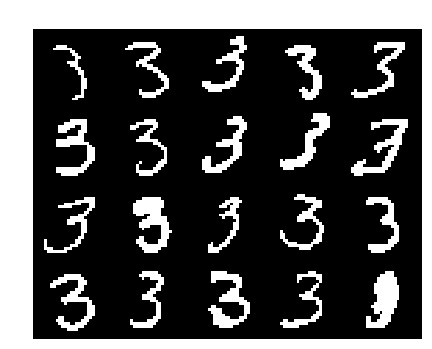

In [6]:
print_image(X_train[1160:1180, :], output_shape=(4, 5))
None # should be binarized

## (a) Basic generalization

#### Model initialization

Weights $W \in \mathbb{R}^{n_{hidden} \times n_{visible}}$ are initialized from a $\mathrm{Unif}(-u, u)$ where $u = \frac{\sqrt{6}}{\sqrt{n_{visible}+n_{hidden}}}$, as described in the lecture.

In [7]:
rbm = RBM(n_visible=784, n_hidden=100, k=1,
          learning_rate=0.1, early_stopping=False,
          seed=900)

In [8]:
rbm.W.shape, rbm.b.shape, rbm.c.shape

((100, 784), (100, 1), (784, 1))

#### Training

In [9]:
n_epoch = 200
rbm.train(X_train, X_valid,
          batch_size=200, n_epoch=n_epoch, batch_seed=25, 
          verbose=True)
None

|-------|---------------------------|---------------------------|
| Epoch |         Training          |         Validation        |
|-------|---------------------------|---------------------------|
|   #   |       Cross-Entropy       |       Cross-Entropy       |
|-------|---------------------------|---------------------------|
|    1  |          90.97478         |          89.51733         |
|    2  |          86.57936         |          83.31232         |
|    3  |          80.72494         |          79.96907         |
|    4  |          82.37904         |          78.33550         |
|    5  |          78.50416         |          78.87556         |
|    6  |          79.23223         |          76.78780         |
|    7  |          73.06943         |          75.72294         |
|    8  |          72.54666         |          72.72097         |
|    9  |          73.91987         |          72.50722         |
|   10  |          68.72566         |          71.36544         |
|   11  | 

As requested in the homework, we now train 5 more neural networks with different initializations.

In [ ]:
nns = [nn]
for i in range(1, 6):
    nn0 = NN(architecture=[784, 100, 10], 
             activation='sigmoid', learning_rate=0.2, momentum=0.0,
             weight_decay=1e-4, dropout=0.0, early_stopping=False, 
             seed=44*i)
    nn0.train(X_train, y_train, X_valid, y_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=21*i,
              verbose=False)  # silent run
    nns.append(nn0)
    print('NN #{:d} training complete ({:d} epochs)'.format(i, n_epoch))
    print('Training loss: {:.5f}'.format(nn0.training_loss[-1][1]))
    print('Validation loss: {:.5f}'.format(nn0.validation_loss[-1][1]))

It appears that the validation cross-entropy losses are roughly the same across different initializations. We proceed with the first model before it started overfitting.

#### Cross-entropy plot

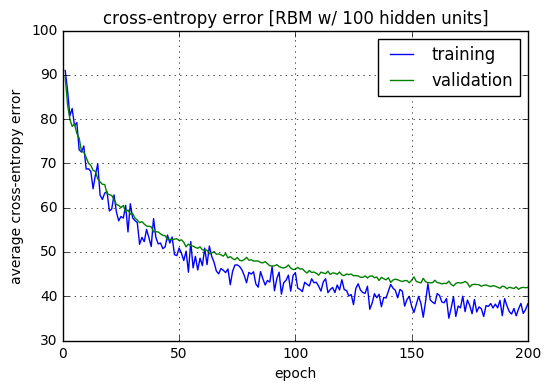

In [18]:
plt.grid()
plt.plot(*zip(*rbm.training_error), label='training')
plt.plot(*zip(*rbm.validation_error), label='validation')
plt.title('RBM cross-entropy [100 hidden units, lr=%.3f]'.format(rbm.learning_rate.const))
plt.xlabel('epoch')
plt.ylabel('average cross-entropy error')
plt.legend()
plt.show()

While the cross-entropy loss for training data goes to zero fairly smoothly and quickly, testing loss stops decreasing around 50 epochs and start to slowly increase since then (i.e. overfitting). This is consistent with our discussion in problem 1.

## (c) Visualizing parameters

First, we take the first hidden layer units and plot them as images.

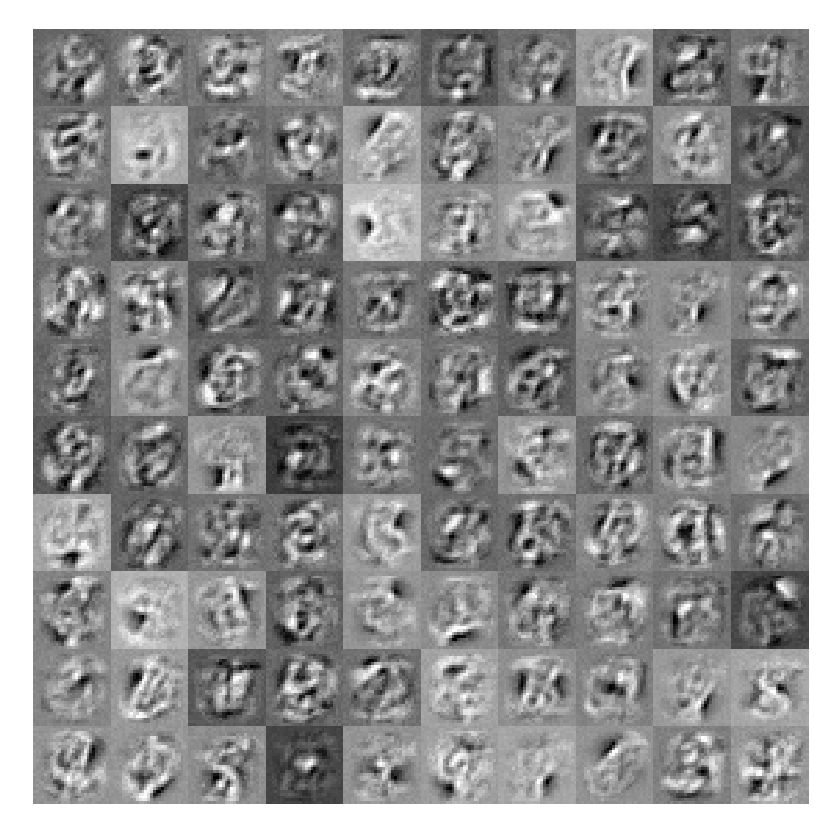

In [12]:
assert rbm.W.shape[0] >= 100
print_image(rbm.W[:100,:], output_shape=(10, 10))
None

Next, we generate 25 new negative samples randomly generated from the trained RBM.

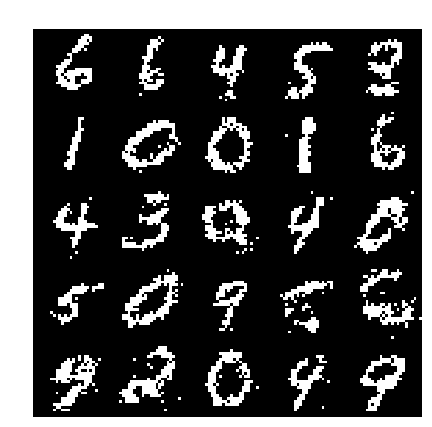

In [17]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 25, replace=False)

X_neg = rbm.generate_negative_sample(X_train[subset, :])
print_image(X_neg, output_shape=(5, 5))
None

Currently, the results don't seem to display many patterns (except that some units seem to be sparse), but they will improve once we apply momentum, dropout, and fine-tuning.

## (d) Learning rate

First, we play with the constant learning rate itself, all others equal. We include early stopping (criteria: validation cross-entropy is larger than in the three previous epochs) to speed up the running time and, if applicable, see at what epoch early stopping happened.

In [ ]:
nns = []
lrs = [.01, .1, .2, .5]
for i, lr in enumerate(lrs):
    nn0 = NN(architecture=[784, 100, 10], 
             activation='sigmoid', learning_rate=lr, momentum=0.0,
             weight_decay=1e-4, dropout=0.0, early_stopping=True, 
             seed=412)
    nn0.train(X_train, y_train, X_valid, y_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25,
              verbose=False)  # silent run
    nns.append(nn0)
    print('NN #{:d} (lr={:.2f}) training complete ({:d} epochs)'.format(i+1, lr, n_epoch))
    print('Training  : cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.training_loss[-1][1], nn0.training_error[-1][1]))
    print('Validation: cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.validation_loss[-1][1], nn0.validation_error[-1][1]))

Learning rate of 0.01 took all 200 epoches and got the highest cross-entropy loss, which could mean that the rate of updates is too slow. Other three rates achieved comparable validation loss, but the epoch at which they early-stopped is different in the orders of magnitude (epochs 139, 68, and 32 respectively for learning rates 0.1, 0.2, and 0.5).

Next, we compare the effects of applying momentum. We use `lr=0.20`, which seems to give a reasonable progress.

In [ ]:
nns = []
betas = [0.0, 0.5, 0.9]
for i, beta in enumerate(betas):
    nn0 = NN(architecture=[784, 100, 10], 
             activation='sigmoid', learning_rate=0.2, momentum=beta,
             weight_decay=1e-4, dropout=0.0, early_stopping=True, 
             seed=412)
    nn0.train(X_train, y_train, X_valid, y_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25,
              verbose=False)  # silent run
    nns.append(nn0)
    print('NN #{:d} (momentum={:.2f}) training complete ({:d} epochs)'.format(i+1, beta, n_epoch))
    print('Training  : cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.training_loss[-1][1], nn0.training_error[-1][1]))
    print('Validation: cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.validation_loss[-1][1], nn0.validation_error[-1][1]))

Momentum gave a significant increase in training, as the stabilizing validation loss was achieved in just 17 (68 without momentum) epochs when using momentum of 0.9. 

To choose the best value of learning rate and momentum, we would have to use cross-validation with (perhaps more lenient) early stopping rules. This will allow us to choose the most reasonable parameter without overfitting.

## (e) Number of hidden units

Given the previous results, we use learning rate 0.2, momentum 0.5, and vary the number of hidden units. 

In [ ]:
nns = []
n_units = [20, 100, 200, 500]
for i, n_unit in enumerate(n_units):
    nn0 = NN(architecture=[784, n_unit, 10], 
             activation='sigmoid', learning_rate=0.01, momentum=0.5,
             weight_decay=1e-4, dropout=0.0, early_stopping=True, 
             seed=412)
    nn0.train(X_train, y_train, X_valid, y_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25,
              verbose=False)  # silent run
    nns.append(nn0)
    print('NN #{:d} (n_unit={:d}) training complete ({:d} epochs)'.format(i+1, n_unit, n_epoch))
    print('Training  : cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.training_loss[-1][1], nn0.training_error[-1][1]))
    print('Validation: cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.validation_loss[-1][1], nn0.validation_error[-1][1]))

While using more hidden layers allows bigger model complexity and capacity, it also requires more training and regularization. In this reesult, it seems that 200 epochs with a relatively small learning rate (0.01) is not enough for these networks, but at least we see that there is no significant improvement in using 200 units instead of 100 units, for example. It does seem like using 500 units will allow better performance, but the computation and convergence also takes much longer.

## (f) Dropout

Now we will use dropout with a good set of parameters we had so far, except we will use a 500-unit network since we'll drop out half of it at any given time. 

In [ ]:
nn0 = NN(architecture=[784, 500, 10], 
         activation='sigmoid', learning_rate=0.2, momentum=0.5,
         weight_decay=1e-4, dropout=0.5, early_stopping=True, 
         seed=412)
nn0.train(X_train, y_train, X_valid, y_valid,
          batch_size=200, n_epoch=n_epoch, batch_seed=25,
          verbose=False)  # silent run
nns.append(nn0)
print('NN #{:d} (dropout=0.5) training complete ({:d} epochs)'.format(i+1, n_epoch))
print('Training  : cross-entropy {:.5f}, error {:.5f}'\
      .format(nn0.training_loss[-1][1], nn0.training_error[-1][1]))
print('Validation: cross-entropy {:.5f}, error {:.5f}'\
      .format(nn0.validation_loss[-1][1], nn0.validation_error[-1][1]))

With dropout, we were able to train a larger network than usual at a smaller running time and with faster convergence (early stopping at 32). This was expected, as we are effectively training an $2^{n_{unit}}$ ensemble of neural nets.

## (g) Best performance single-layer network

Since searching over the grid of many hyperparameters is fairly difficult, we cross-validate over a subset of hyperparameters that we learned were reasonable choices.

In [ ]:
import itertools as it

lrs      = [0.1, 0.2]
betas    = [0.5, 0.9]
n_units  = [200, 500]
earlys   = [True, False]
decays   = [1e-4, 1e-6]
dropouts = [0.5, 0.75]

nns      = []
for i, (lr, beta, n_unit, early, decay, dropout) in \
    enumerate(it.product(lrs, betas, n_units, earlys, decays, dropouts)):
    nn0 = NN(architecture=[784, n_unit, 10], 
             activation='sigmoid', learning_rate=lr, momentum=beta,
             weight_decay=decay, dropout=dropout, early_stopping=early, 
             seed=412)
    nn0.train(X_train, y_train, X_valid, y_valid,
              batch_size=200, n_epoch=n_epoch, batch_seed=25,
              verbose=False)  # silent run
    nns.append(nn0)
    print('NN #{:d} Hyperparameters: {:.1f}, {:.1f}, {:d}, {:d}, {:.4f}, {:.1f}'\
          .format(i+1, lr, beta, n_unit, int(early), decay, dropout))
    print('training complete ({:d} epochs)'.format(n_epoch))
    print('Training  : cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.training_loss[-1][1], nn0.training_error[-1][1]))
    print('Validation: cross-entropy {:.5f}, error {:.5f}'\
          .format(nn0.validation_loss[-1][1], nn0.validation_error[-1][1]))

We select two models with the least error rate: one that ran in full 200 epochs (#63) and one that early-stopped (#60).

In [ ]:
nn1 = nns[61]
nn2 = nns[59]

In [ ]:
train_loss  = nn1.compute_cross_entropy(X_train, y_train)
train_error = nn1.compute_error(X_train, y_train)
valid_loss  = nn1.compute_cross_entropy(X_valid, y_valid)
valid_error = nn1.compute_error(X_valid, y_valid)
test_loss   = nn1.compute_cross_entropy(X_test, y_test)
test_error  = nn1.compute_error(X_test, y_test)

print('NN #{:d} Hyperparameters: {:.1f}, {:.1f}, {:d}, {:d}, {:.4f}, {:.1f}'\
          .format(i+1, lr, beta, n_unit, int(early), decay, dropout))
print('Training  : cross-entropy {:.5f}, error rate {:.5f}'\
      .format(train_loss, train_error))
print('Validation: cross-entropy {:.5f}, error rate {:.5f}'\
      .format(valid_loss, valid_error))
print('Testing   : cross-entropy {:.5f}, error rate {:.5f}'\
      .format(test_loss , test_error ))

In [ ]:
train_loss  = nn2.compute_cross_entropy(X_train, y_train)
train_error = nn2.compute_error(X_train, y_train)
valid_loss  = nn2.compute_cross_entropy(X_valid, y_valid)
valid_error = nn2.compute_error(X_valid, y_valid)
test_loss   = nn2.compute_cross_entropy(X_test, y_test)
test_error  = nn2.compute_error(X_test, y_test)

print('NN #{:d} Hyperparameters: {:.1f}, {:.1f}, {:d}, {:d}, {:.4f}, {:.1f}'\
          .format(i+1, lr, beta, n_unit, int(early), decay, dropout))
print('Training  : cross-entropy {:.5f}, error rate {:.5f}'\
      .format(train_loss, train_error))
print('Validation: cross-entropy {:.5f}, error rate {:.5f}'\
      .format(valid_loss, valid_error))
print('Testing   : cross-entropy {:.5f}, error rate {:.5f}'\
      .format(test_loss , test_error ))

Both estimators give an approximate rate of 10.8%. Plotting the training error curve for the first one, which ran the full 200 epochs, we see that the errors stabilize pretty quickly (below). This can be either because we need better gradient steps or the model capacity is too small.

In [ ]:
# Error rate
plt.grid()
plt.plot(*zip(*nn1.training_error), label='training')
plt.plot(*zip(*nn1.validation_error), label='validation')
plt.title('classification error [1 hidden layer]')
plt.xlabel('epoch')
plt.ylabel('average error rate')
plt.legend()
plt.show()

We can also visualize the first layer filters and units. Both of these models used 500 hidden units, but here we just show the first 200 of the second model.

In [ ]:
assert nn1.layers[0].W.shape[0] >= 200
print_image(nn1.layers[0].W[:200,:], output_shape=(10, 20))
None

The filters were able to separate out the borders and focus on the central part where there are digits. A lot of the filters seem to do a kind of edge/shape detection within the inner circle, some of them sharper than others. In general, there seem to be contrasts within each filter that forms an edge detector. 

In [ ]:
rng    = np.random.RandomState(1)
subset = rng.choice(np.arange(X_train.shape[0]), 50, replace=False)

h = nn1.layers[0].fprop(X_train[subset, :])
plt.matshow(h[:,:200])
plt.xlabel('first hidden layer (first 200 units)')
plt.ylabel('random samples') 
plt.xticks([])
plt.yticks([])
None

There seem to be a lot more of saturated units than the two-hidden-layer result. As a result, some of the columns appear to be highly correlated. It does appear that, while both this and the two-hidden-layer networks achieve similar accuracy (within limited training time), the two-hidden-layer network seem to have a better/sparser representation of the data.

## (h) Extension to multiple layers

The current implementation accepts arbitrarily many layers (in theory). Please see the other notebook, `nn_mnist_multilayer.ipynb`, for an implementation of a two-hidden-layer neural network. 